In [1]:
#Importing Packages
import numpy as np
from tinygp import kernels, GaussianProcess
import jax
from jax import random
import jax.numpy as jnp
import matplotlib.pyplot as plt
import arviz as az
from src.model_fitting_functions import run_inference
from src.examples_functions import tinygp_model,tinygp_2process_model,truth_posterior_predictive,bias_posterior_predictive,posterior_predictive_realisations,singleprocess_posterior_predictive_realisations

plt.rcParams['lines.markersize'] = 3
plt.rcParams['lines.linewidth'] = 0.4

rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
jax.config.update("jax_enable_x64", True)

In [2]:
#Creating Underlying Process Data 

X = jnp.arange(0,120,0.1)

#Truth
GP = GaussianProcess(1 * kernels.ExpSquared(1),X,diag=1e-5,mean=1.0)
Y = GP.sample(rng_key)

#Bias
GP2 = GaussianProcess(1 * kernels.ExpSquared(5),X,diag=1e-5,mean=-1.0)
rng_key, rng_key_ = random.split(rng_key)
Y2 = GP2.sample(rng_key)

In [3]:
# Creating sudo 'Observation' and 'Climate Model' examples and transforming to jax arrays

mask = np.ones(len(X),dtype='bool')
mask[slice(int(len(X)/3),int(len(X)*2/3))]=False

ox = X[mask][::20]
odata = Y[mask][::20]

cx = X[::10] 
cdata = (Y+Y2)[::10] 

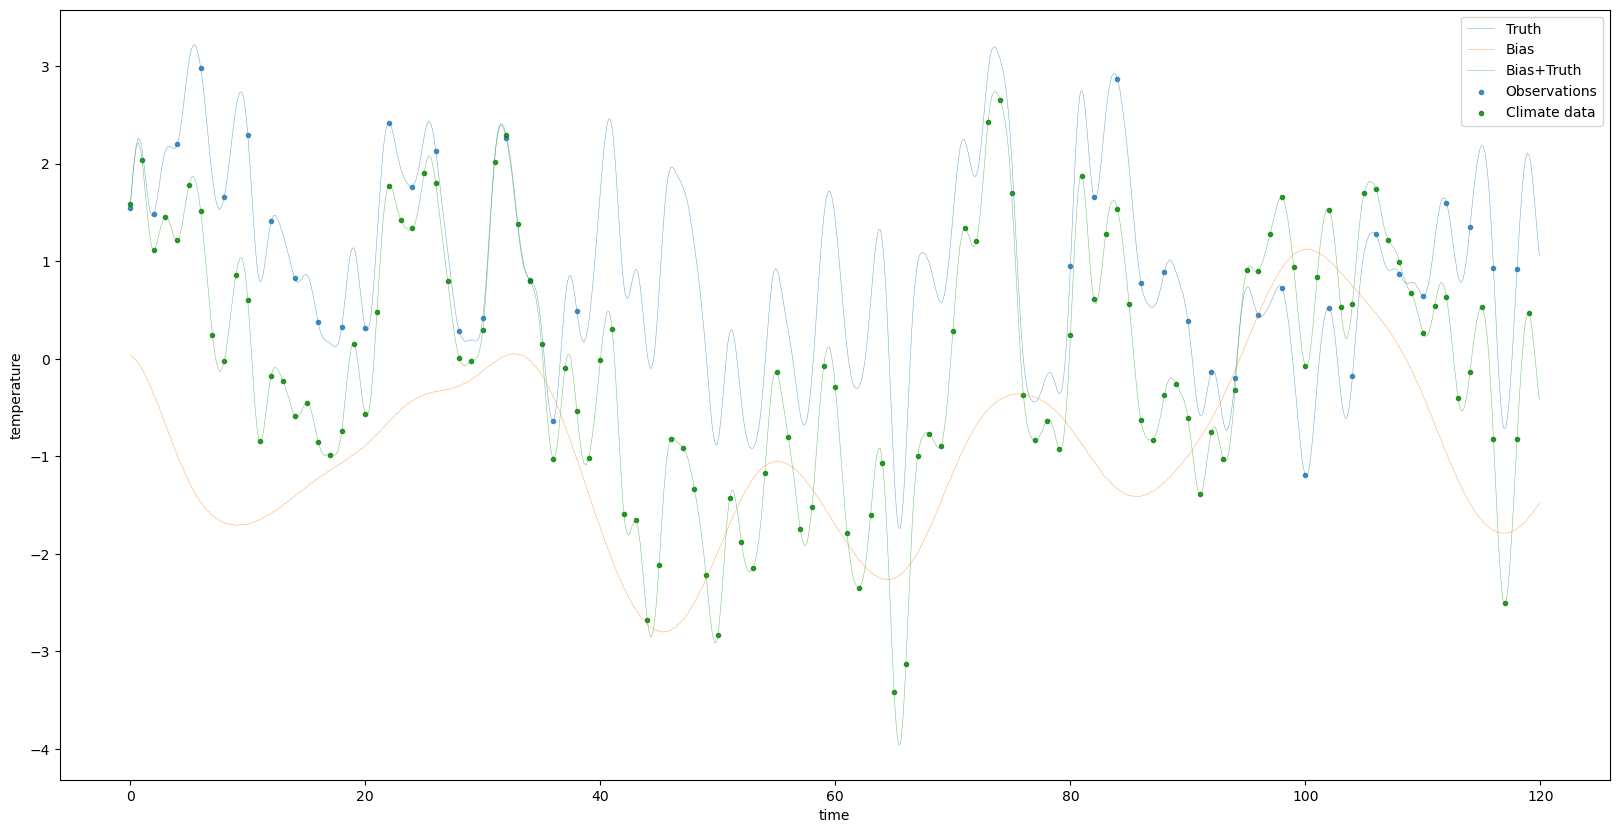

In [4]:
#Plotting data
plt.figure(figsize=(20,10))

plt.plot(X,Y,label='Truth',alpha=0.6)
plt.plot(X,Y2,label='Bias',alpha=0.6)
plt.plot(X,Y+Y2,label='Bias+Truth',alpha=0.6)

plt.scatter(ox,odata,label='Observations',alpha=0.8)
plt.scatter(cx,cdata,color='g',label='Climate data',alpha=0.8)

plt.xlabel('time')
plt.ylabel('temperature')
plt.legend()

In [5]:
mcmc_2process = run_inference(tinygp_2process_model, rng_key_, 1000, 2000, cx,ox=ox,cdata=cdata,odata=odata,noise=1e-5)

sample: 100%|██████████| 3000/3000 [01:32<00:00, 32.41it/s, 7 steps of size 5.13e-01. acc. prob=0.88] 



                    mean       std    median      5.0%     95.0%     n_eff     r_hat
     bkern_var      2.07      1.21      1.77      0.51      3.76   1326.65      1.00
  blengthscale      7.11      2.62      6.80      3.12     10.87   1368.12      1.00
         bmean     -0.92      0.55     -0.93     -1.82     -0.02   1789.12      1.00
      kern_var      0.93      0.15      0.92      0.69      1.16   1582.31      1.00
   lengthscale      0.97      0.04      0.97      0.90      1.05   1489.07      1.00
          mean      1.00      0.17      1.00      0.72      1.28   2133.09      1.00

Number of divergences: 0
Time Taken: 97.90148530900478


In [6]:
mcmc_obs = run_inference(tinygp_model, rng_key_, 1000, 2000, ox,data=odata,noise=1e-5)
mcmc_climate = run_inference(tinygp_model, rng_key_, 1000, 2000, cx,data=cdata,noise=1e-5)

sample: 100%|██████████| 3000/3000 [00:12<00:00, 232.59it/s, 3 steps of size 4.53e-01. acc. prob=0.94] 



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
     kern_var      1.09      0.32      1.04      0.62      1.56    968.93      1.00
  lengthscale      1.36      0.21      1.38      1.03      1.69    679.09      1.00
         mean      1.01      0.22      1.01      0.68      1.40   1421.57      1.00

Number of divergences: 0
Time Taken: 13.58926397189498


sample: 100%|██████████| 3000/3000 [00:34<00:00, 88.19it/s, 3 steps of size 6.10e-01. acc. prob=0.91]  



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
     kern_var      1.59      0.26      1.56      1.17      1.98   1113.99      1.00
  lengthscale      1.06      0.04      1.06      1.01      1.12   1187.75      1.00
         mean     -0.01      0.20     -0.01     -0.33      0.29   1574.50      1.00

Number of divergences: 0
Time Taken: 34.53656778857112


In [7]:
#Saving Output from MCMC
outfile_dir = '/home/jez/Bias_Correction/data/Examples_Output/'

idata_2process = az.from_numpyro(mcmc_2process)
idata_obs = az.from_numpyro(mcmc_obs)
idata_climate = az.from_numpyro(mcmc_climate)

idata_2process.to_netcdf(f'{outfile_dir}idata_2process.nc')
idata_obs.to_netcdf(f'{outfile_dir}idata_obs.nc')
idata_climate.to_netcdf(f'{outfile_dir}idata_climate.nc')

'/home/jez/Bias_Correction/data/Examples_Output/idata_climate.nc'

In [8]:
#Loading Output from MCMC
outfile_dir = '/home/jez/Bias_Correction/data/Examples_Output/'

idata_2process = az.from_netcdf(f'{outfile_dir}idata_2process.nc')
idata_obs = az.from_netcdf(f'{outfile_dir}idata_obs.nc')
idata_climate = az.from_netcdf(f'{outfile_dir}idata_climate.nc')

In [9]:
nx = X[::5] # locations where predictions will be made

In [10]:
#Realisations

num_parameter_realisations = 20
num_posterior_pred_realisations = 20

truth_realisations = posterior_predictive_realisations(truth_posterior_predictive,nx,ox,cx,odata,cdata,idata_2process,num_parameter_realisations,num_posterior_pred_realisations)
truth_realisations = truth_realisations.reshape(-1,truth_realisations.shape[-1])

bias_realisations = posterior_predictive_realisations(bias_posterior_predictive,nx,ox,cx,odata,cdata,idata_2process,num_parameter_realisations,num_posterior_pred_realisations)
bias_realisations = bias_realisations.reshape(-1,bias_realisations.shape[-1])

100%|██████████| 20/20 [00:02<00:00,  9.81it/s]


In [11]:
# Single process realisations
sp_truth_realisations = singleprocess_posterior_predictive_realisations(nx,ox,idata_obs,num_parameter_realisations,num_posterior_pred_realisations)
sp_truth_realisations = sp_truth_realisations.reshape(-1,sp_truth_realisations.shape[-1])
sp_climate_realisations = singleprocess_posterior_predictive_realisations(nx,cx,idata_climate,num_parameter_realisations,num_posterior_pred_realisations)
sp_climate_realisations = sp_climate_realisations.reshape(-1,sp_climate_realisations.shape[-1])

100%|██████████| 20/20 [00:08<00:00,  2.39it/s]


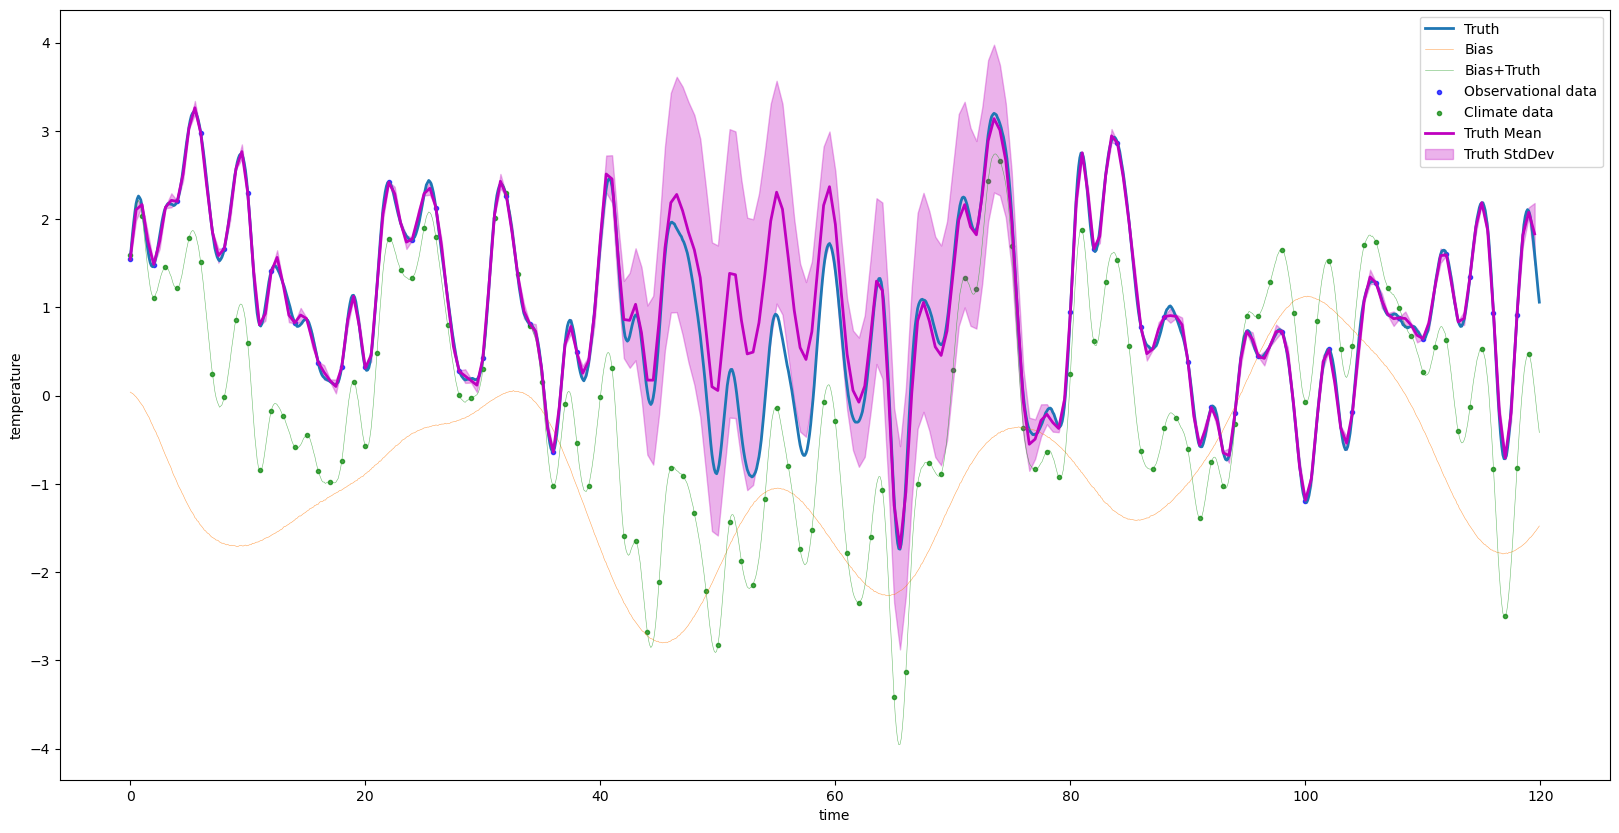

In [12]:
#Plotting Posterior Predictive for Truth
plt.figure(figsize=(20,10))

plt.plot(X,Y,label='Truth',alpha=1.0,linewidth=2)
plt.plot(X,Y2,label='Bias',alpha=0.7)
plt.plot(X,Y+Y2,label='Bias+Truth',alpha=0.7)

plt.scatter(ox,odata,color='b',label='Observational data',alpha=0.7)
plt.scatter(cx,cdata,color='g',label='Climate data',alpha=0.7)

truth_pred_mean = truth_realisations.mean(axis=0)
truth_pred_std = truth_realisations.std(axis=0)
plt.plot(nx,truth_pred_mean,label='Truth Mean',color='m',alpha=1.0,linewidth=2)
plt.fill_between(nx,truth_pred_mean+truth_pred_std,truth_pred_mean-truth_pred_std,label='Truth StdDev',color='m',alpha=0.3)

plt.xlabel('time')
plt.ylabel('temperature')
plt.legend()

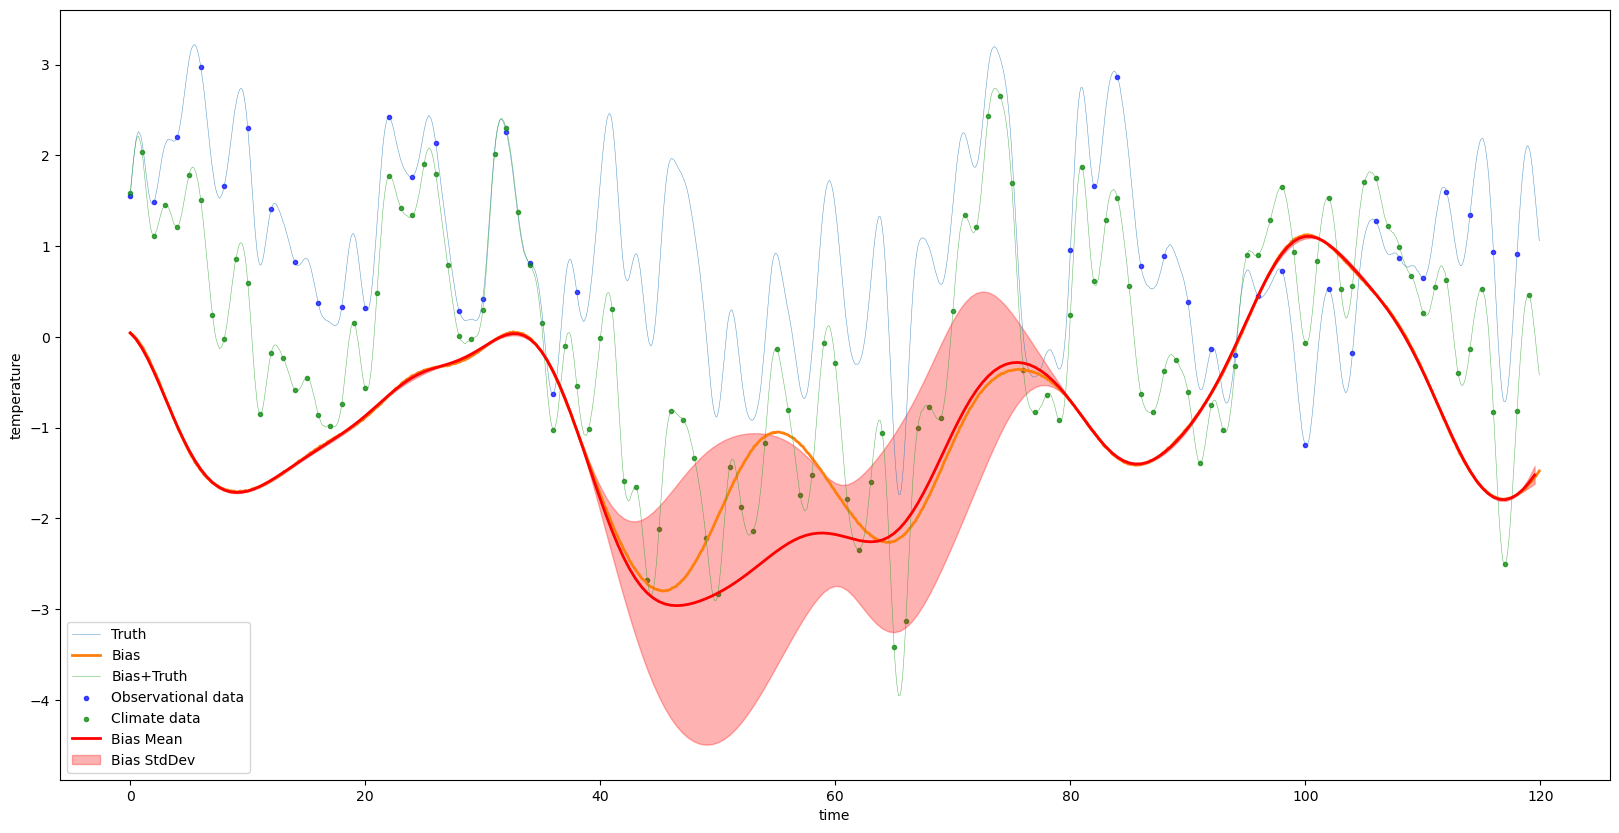

In [13]:
#Plotting Posterior Predictive for Bias
plt.figure(figsize=(20,10))

plt.plot(X,Y,label='Truth',alpha=0.7)
plt.plot(X,Y2,label='Bias',alpha=1,linewidth=2)
plt.plot(X,Y+Y2,label='Bias+Truth',alpha=0.7)

plt.scatter(ox,odata,color='b',label='Observational data',alpha=0.7)
plt.scatter(cx,cdata,color='g',label='Climate data',alpha=0.7)

bias_pred_mean = bias_realisations.mean(axis=0)
bias_pred_std = bias_realisations.std(axis=0)
plt.plot(nx,bias_pred_mean,label='Bias Mean',color='r',alpha=1.0,linewidth=2)
plt.fill_between(nx,bias_pred_mean+bias_pred_std,bias_pred_mean-bias_pred_std,label='Bias StdDev',color='r',alpha=0.3)

plt.xlabel('time')
plt.ylabel('temperature')
plt.legend()

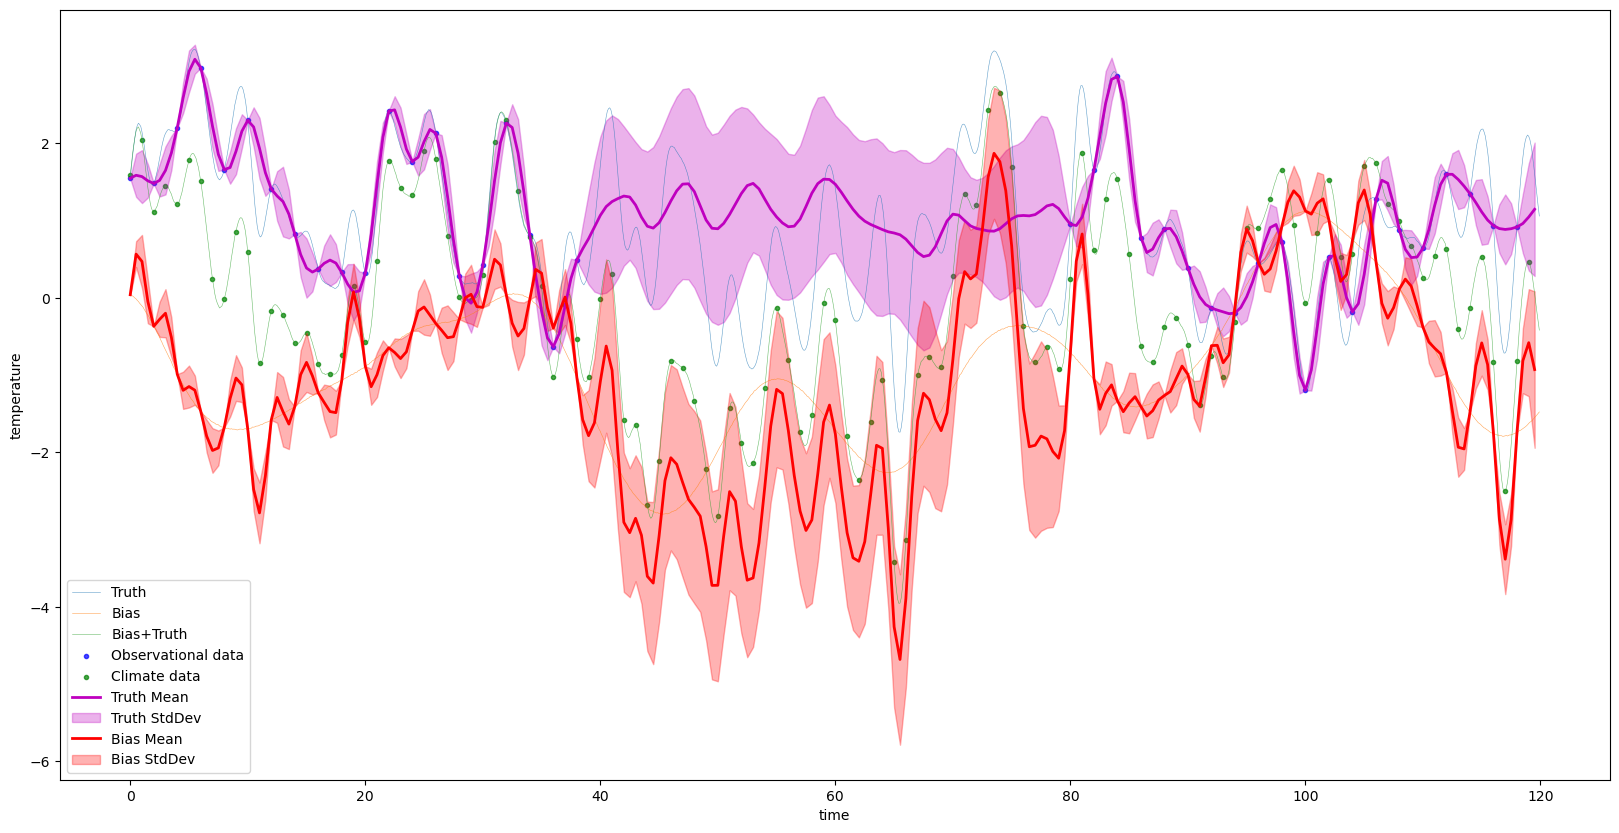

In [14]:
#Plotting Posterior Predictive for Single Process Model

plt.figure(figsize=(20,10))

plt.plot(X,Y,label='Truth',alpha=0.7)
plt.plot(X,Y2,label='Bias',alpha=0.7)
plt.plot(X,Y+Y2,label='Bias+Truth',alpha=0.7)

plt.scatter(ox,odata,color='b',label='Observational data',alpha=0.7)
plt.scatter(cx,cdata,color='g',label='Climate data',alpha=0.7)

sp_truth_pred_mean = sp_truth_realisations.mean(axis=0)
sp_truth_pred_std = sp_truth_realisations.std(axis=0)
plt.plot(nx,sp_truth_pred_mean,label='Truth Mean',color='m',alpha=1.0,linewidth=2)
plt.fill_between(nx,sp_truth_pred_mean+sp_truth_pred_std,sp_truth_pred_mean-sp_truth_pred_std,label='Truth StdDev',color='m',alpha=0.3)

sp_bias_pred_mean = (sp_climate_realisations-sp_truth_realisations).mean(axis=0)
sp_bias_pred_std = (sp_climate_realisations-sp_truth_realisations).std(axis=0)
plt.plot(nx,sp_bias_pred_mean,label='Bias Mean',color='r',alpha=1.0,linewidth=2)
plt.fill_between(nx,sp_bias_pred_mean+sp_bias_pred_std,sp_bias_pred_mean-sp_bias_pred_std,label='Bias StdDev',color='r',alpha=0.3)

plt.xlabel('time')
plt.ylabel('temperature')
plt.legend()